## DataLoading

In [1]:
import torch
import torchvision
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
transform = T.Compose([
    T.ToTensor()
])
dataset = torchvision.datasets.CIFAR10(root = './data',train=True,download=True,transform=transform)
trainset, valset = torch.utils.data.random_split(dataset, [len(dataset) - int(len(dataset) * 0.2), int(len(dataset) * 0.2)])
testset = torchvision.datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
trainloader = torch.utils.data.DataLoader(trainset,batch_size = None)
valloader = torch.utils.data.DataLoader(valset,batch_size = None)
testloader = torch.utils.data.DataLoader(testset,batch_size = None)

## DataSet Check

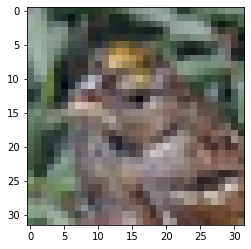

bird


In [4]:
def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(classes[labels])
    

## Dataset Setting

In [5]:
train_x = []
train_y = []
for i,(image,label) in tqdm(enumerate(trainloader)):
    if i == 1000:
        break
    image = image.permute(1,2,0)
    image = image.numpy()
    train_x.append(image)
    train_y.append(label)
train_x = np.array(train_x)
train_y = np.array(train_y)

1000it [00:00, 11355.11it/s]


In [6]:
val_x = []
val_y = []
for i,(image,label) in tqdm(enumerate(trainloader)):
    if i == 200:
        break
    image = image.permute(1,2,0)
    image = image.numpy()
    val_x.append(image)
    val_y.append(label)
val_x = np.array(val_x)
val_y = np.array(val_y)

200it [00:00, 11112.06it/s]


In [7]:
test_x = []
test_y = []
for i,(image,label) in tqdm(enumerate(testloader)):
    if i == 100:
        break
    image = image.permute(1,2,0)
    image = image.numpy()
    test_x.append(image)
    test_y.append(label)
test_x = np.array(test_x)
test_y = np.array(test_y)

100it [00:00, 10993.09it/s]


In [8]:
torch.manual_seed(1)
train_tmp = torch.randn(100,32,32,3).numpy()
test_tmp = torch.randn(32,32,3).numpy()
distance = np.abs(train_tmp - test_tmp)
dis_list = np.sum(distance.reshape(train_tmp.shape[0],-1),axis=1)
np.argmin(dis_list)


75

## Nearest Neighbor

In [9]:
class NN:
    def __init__(self,loss = 'L1'):
        self.loss = loss
        
    def fit(self,X,y):
        self.image = X
        self.label = y
        
    def predict(self,X):
        num_test = X.shape[0]
        y_pred = np.zeros(num_test)
        for i in range(num_test):
            if self.loss == 'L1':
                distance = np.abs(self.image - X[i,:]) # L1 거리계산
            elif self.loss == 'L2':
                distance = np.square(self.image - X[i,:]) # L2 거리계산
            else:
                raise ValueError
            distance = np.sum(distance.reshape(self.image.shape[0],-1),axis=1) # image classification
            min_index = np.argmin(distance)
            y_pred[i] = self.label[min_index]
        return y_pred

In [10]:
from sklearn.metrics import accuracy_score

for loss in ['L1','L2']:
    model = NN(loss)
    model.fit(train_x,train_y)
    pred = model.predict(test_x)
    score = accuracy_score(test_y,pred)
    print(f'{loss} Loss : {score}')

L1 Loss : 0.28
L2 Loss : 0.22


## KNN

In [11]:
class KNN:
    def __init__(self,k = 5,loss = 'L1'):
        self.loss = loss
        self.k = k
    def fit(self,X,y):
        self.image = X
        self.label = y
        
    def predict(self,X):
        num_test = X.shape[0]
        y_pred = np.zeros(num_test)
        for i in range(num_test):
            if self.loss == 'L1':
                distance = np.abs(self.image - X[i,:])
            elif self.loss == 'L2':
                distance = np.square(self.image - X[i,:])
            else:
                raise ValueError
            distance = np.sum(distance.reshape(self.image.shape[0],-1),axis=1)
            dis_list = [(dis,idx) for dis,idx in zip(distance,range(len(distance)))] # 거리-인덱스 저장
            pred_list = sorted(dis_list)[:self.k] # 최소거리 k 개 후보 추출
            first = pred_list[0] # 우선순위 1순위 저장
            k_label_list=self.label[np.array(pred_list,dtype=np.int32)[:,1]] # label값 리스트 추출
            uni,cnt = np.unique(k_label_list,return_counts=True)
            if len(uni)>2 and cnt[0] == cnt[1]: # 동일 순위 검사
                y_pred[i] = self.label[first[1]] # 동일 순위시 1순위로 예측
            else:
                y_pred[i] = max(k_label_list)
        return y_pred

In [13]:
for loss in ['L1','L2']:
    for k in range(2,7):
        model = KNN(k,loss)
        model.fit(train_x,train_y)
        pred = model.predict(test_x)
        score = accuracy_score(test_y,pred)
        print(f'{loss} Loss - {k}: {score}')

L1 Loss - 2: 0.21
L1 Loss - 3: 0.25
L1 Loss - 4: 0.3
L1 Loss - 5: 0.27
L1 Loss - 6: 0.31
L2 Loss - 2: 0.28
L2 Loss - 3: 0.26
L2 Loss - 4: 0.27
L2 Loss - 5: 0.25
L2 Loss - 6: 0.23
